# Example: Satellite Parallax

In this example, we calculate the photometric amplification curves for the OB170896 event published in Shvartzvald et al. 2019. This event was observed both from ground-based telescopes and Spitzer. We use BAGLE to reproduce the lightcurve seen from both locations. 

The event parameters are taken from the ++ solution in Table 1. 

| Param         | Value      | units    |
|---------------|------------|----------|
| $t_{0,geotr}$ | 7911.05582 | HJD days |
| $u_{0,geotr}$ | 0.0039     |          |
| $t_{E,geotr}$ | 14.883     | days     |
| $\pi_{E,E,geotr}$ | −0.615 |          |
| $\pi_{E,N,geotr}$ | −0.779 |          |

Note that all of these parameters are in the geocentric-transformed coordinate system where the rectilinear transform is performed at $t_{0,par} = t_{0,geotr}$.



In [1]:
import pylab as plt
from bagle import model
from bagle import frame_convert as fc
import numpy as np

# Scenario from Shvartzvald et al. 2019
# Target: OB170896: +,+ solution (see Table 1)
raL = (17. + 57./60.)  * 15.0  # in degrees
decL = -(27. + 13./60.)
t0_geotr = 57911.05582
u0_geotr = 0.0039
tE_geotr = 14.883
piEN_geotr = -0.779
piEE_geotr = -0.615
t0par = t0_geotr

The brightness of the event was not reported in the table, so we will guess some values.

In [2]:
# Guessed these values based on Figure 1 -- not reported in table.
mag_src = 17.9
mag_blend = 21.0

f_src = 10**(mag_src / -2.5)
f_blend = 10**(mag_blend / -2.5)
f_base = f_src + f_blend
    
b_sff = f_src / f_base
mag_base = -2.5 * np.log10(f_base)

Convert the parameters from the geocentric-transformed frame into Solar System barycentric, which we prefer to work with in BAGLE.

In [3]:
out = fc.convert_helio_geo_phot(raL, decL,
                                t0_geotr, u0_geotr, tE_geotr,
                                piEE_geotr, piEN_geotr, t0par,
                                in_frame='geo',
                                murel_in='LS', murel_out='SL',
                                coord_in='tb', coord_out='EN',
                                plot=False)

t0_helio = out[0]
u0_helio = out[1]
tE_helio = out[2]
piEE_helio = out[3]
piEN_helio = out[4]

Make two different BAGLE model objects with one at Earth's location and one at Spitzer's location. Note these locations are time dependant and will capture the full motion of each body according to the JPL Ephemeris. 

In [4]:
# Earth parallax
pspl_e = model.PSPL_Phot_Par_Param1(t0_helio,
                                    u0_helio,
                                    tE_helio,
                                    piEE_helio,
                                    piEN_helio,
                                    [b_sff],
                                    [mag_src],
                                    raL=raL,
                                    decL=decL,
                                    obsLocation='earth')
# Spitzer parallax
pspl_s = model.PSPL_Phot_Par_Param1(t0_helio,
                                    u0_helio,
                                    tE_helio,
                                    piEE_helio,
                                    piEN_helio,
                                    [b_sff],
                                    [mag_src],
                                    raL=raL,
                                    decL=decL,
                                    obsLocation='spitzer')

Make lightcurves for each of the above models. 

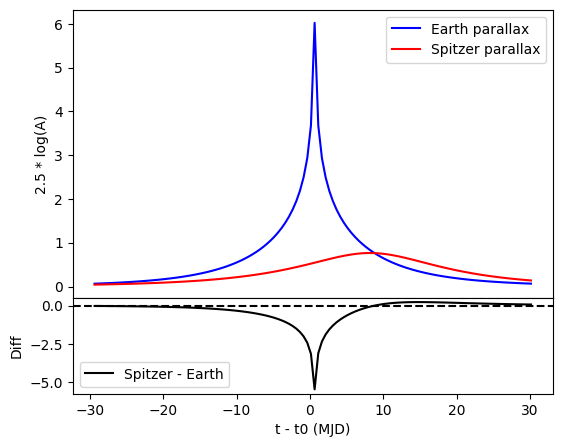

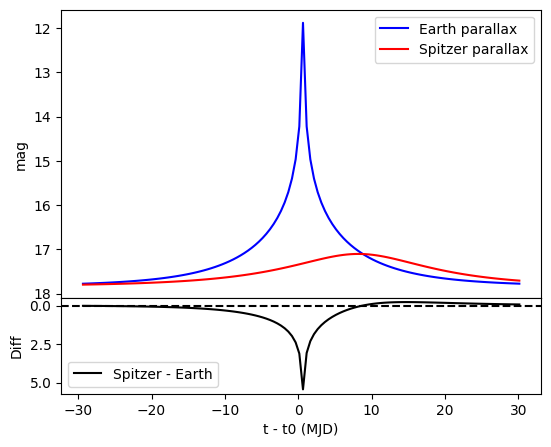

In [6]:
t = np.arange(t0_geotr - 30, t0_geotr + 30, 0.5)
dt = t - pspl_e.t0
A_e = pspl_e.get_amplification(t)
A_s = pspl_s.get_amplification(t)
m_e = pspl_e.get_photometry(t)
m_s = pspl_s.get_photometry(t)

# Plot the amplification
fig1 = plt.figure(1)
plt.clf()
f1_1 = fig1.add_axes((0.20, 0.3, 0.75, 0.6))
plt.plot(dt, 2.5 * np.log10(A_e), 'b-', label='Earth parallax')
plt.plot(dt, 2.5 * np.log10(A_s), 'r-', label='Spitzer parallax')
plt.legend(fontsize=10)
plt.ylabel('2.5 * log(A)')
f1_1.set_xticklabels([])
f2_1 = fig1.add_axes((0.20, 0.1, 0.75, 0.2))
plt.plot(dt, 2.5 * (np.log10(A_s) - np.log10(A_e)), 'k-',
            label='Spitzer - Earth')
plt.axhline(0, linestyle='--', color='k')
plt.legend(fontsize=10)
plt.ylabel('Diff')
plt.xlabel('t - t0 (MJD)')

# Plot the magnitude
fig2 = plt.figure(2)
plt.clf()
f2_1 = fig2.add_axes((0.20, 0.3, 0.75, 0.6))
plt.plot(dt, m_e, 'b-', label='Earth parallax')
plt.plot(dt, m_s, 'r-', label='Spitzer parallax')
plt.legend(fontsize=10)
plt.ylabel('mag')
plt.gca().invert_yaxis()
f2_1.set_xticklabels([])
f2_2 = fig2.add_axes((0.20, 0.1, 0.75, 0.2))
plt.plot(dt, m_s - m_e, 'k-', label='Spitzer - Earth')
plt.axhline(0, linestyle='--', color='k')
plt.legend(fontsize=10)
plt.ylabel('Diff')
plt.xlabel('t - t0 (MJD)')
plt.gca().invert_yaxis()